In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
market_demand = pd.read_csv("FACT_MARKET_DEMAND-001.csv")

#  Q7

Item Description: Peppy Gentle Drink Pink Woodsy .5L Multi Jug
- Caloric Segment: Regular
- Type: SSD
- Manufacturer: Swire-CC
- Brand: Peppy
- Package Type: .5L Multi Jug
- Flavor: ‘Pink Woodsy’

Swire plans to release this product in the Southern region for 13 weeks. What will the forecasted demand be, in weeks, for this product?

## Data Preparation

In [3]:
southern_keys = [
    259, 260, 524, 272, 531, 277, 534, 535, 793, 794, 799, 801, 294, 807, 44,
    557, 310, 825, 316, 831, 323, 585, 849, 862, 866, 867, 358, 365, 622, 367,
    882, 891, 893, 895, 900, 913, 409, 673, 674, 939, 179, 949, 951, 952, 953,
    197, 967, 205, 210, 979, 212, 980, 981, 216, 729, 220, 733, 478, 739, 743,
    746, 748, 238, 754, 759, 766
]

# Filter the DataFrame
southern = market_demand[market_demand['MARKET_KEY'].isin(southern_keys)]

In [4]:
peppy = southern[(southern['BRAND'].str.contains('peppy', case=False, regex=True))]
peppy_regular = peppy[(peppy['CALORIC_SEGMENT'].str.contains('Regular', case=False, regex=True))]
peppy_regular_ssd = peppy_regular[(peppy_regular['CALORIC_SEGMENT'].str.contains('Regular', case=False, regex=True))]
peppy_regular_ssd_multi_jug = peppy_regular_ssd[(peppy_regular_ssd['PACKAGE'].str.contains('Multi Jug', case=False, regex=True))]

In [5]:
df = peppy_regular_ssd_multi_jug[['DATE','UNIT_SALES']].groupby(by="DATE", as_index=False).sum()
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.asfreq('W-SAT')

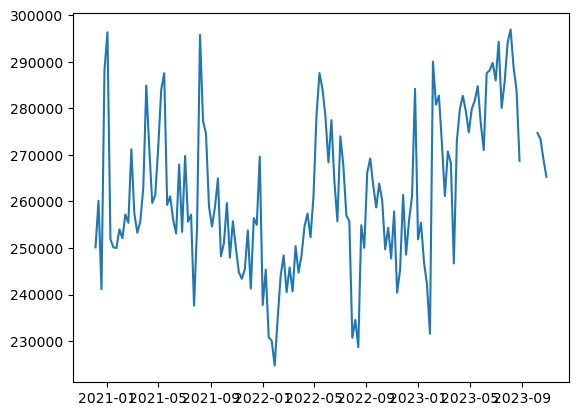

In [6]:
plt.plot(df)

There are NAN in some weeks. as we dig deeper we see that there are no sale on the month of august 2023.

In [7]:
# Train and Test periods
from datetime import datetime

s_date = '2023-06-03'
e_date = '2023-08-26'
df = df.loc[df.index <= e_date]
train_period = df.loc[df.index < s_date]
test_period = df.loc[(df.index >= s_date) & (df.index <= e_date)]


start_forecast = datetime.strptime(s_date, '%Y-%m-%d').date()
end_forecast = datetime.strptime(e_date, '%Y-%m-%d').date()

# Model Performance Metrics Function

We will create and resuse this function to measure each models performance with the data. This will include MAE, MSE, RMSE, MAPE and direct accuracy percentage.

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np

def get_scores(actual, predicted):
    # Calculate errors
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    percentage_diff = np.abs((actual - predicted) / actual) * 100

    # Calculate MAPE
    mape = percentage_diff.mean()

    # Calculate "Accuracy" Percentage
    accuracy_percentage = 100 - mape

    # Print metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"Direct 'Accuracy' Percentage: {accuracy_percentage}%")

    return pd.Series(data={'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'direct_accuracy':accuracy_percentage}, index=['mae', 'mse', 'rmse','mape','direct_accuracy'])

## ARIMA

ARIMA is a statistical model used for time series analysis to forecast future data points by leveraging past data. It combines three main aspects: autoregression (AR), differencing (I) to make the time series stationary, and moving average (MA). The AR part exploits the relationship between an observation and a number of lagged observations, the I part involves differencing the data to achieve stationarity, and the MA part models the error of the observation as a combination of previous error terms.

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model fitting
order = (2, 1, 2)  # Still (p, d, q)

model = ARIMA(train_period['UNIT_SALES'], order=order)
model_fit = model.fit()

# Forecasting
forecast = model_fit.predict(start=start_forecast,
                             end=end_forecast)

arima_forecast = forecast

In [10]:
arima_score = get_scores(test_period.squeeze(), arima_forecast)

MAE: 10610.921900092897
MSE: 133607735.47205538
RMSE: 11558.881237907732
MAPE: 3.682049809516563%
Direct 'Accuracy' Percentage: 96.31795019048344%


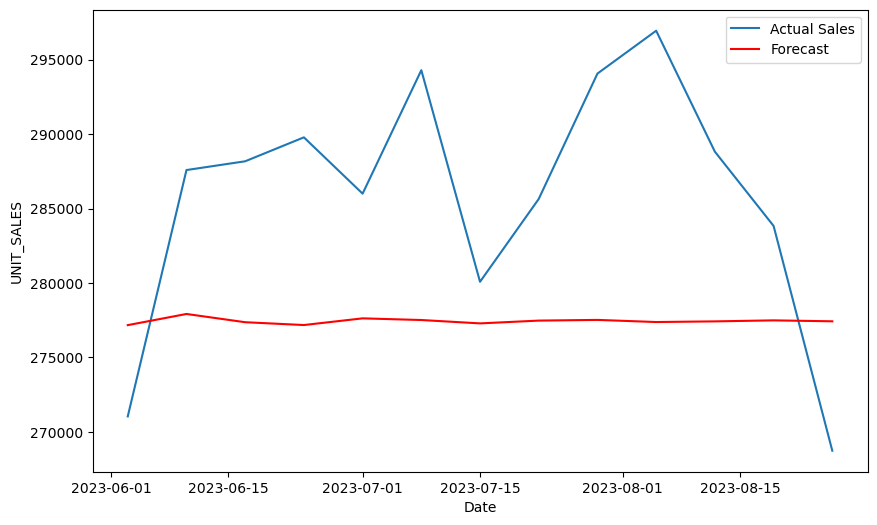

In [11]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(arima_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## SARIMA

SARIMA extends ARIMA by explicitly accommodating and modeling seasonal effects in time series data. It includes additional seasonal elements on top of the AR, I, and MA components.
SARIMA is characterized by its ability to model both non-seasonal and seasonal components of the time series data, making it more versatile than ARIMA for data with clear seasonal patterns, such as sales data around specific holidays or events.
It incorporates additional parameters to handle seasonality, which are seasonal AR, seasonal differencing, and seasonal MA components, allowing it to capture seasonal fluctuations effectively, making it ideal for products with seasonal demand.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# SARIMA Model fitting
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 52)  # (P, D, Q, s)

model = SARIMAX(train_period['UNIT_SALES'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecasting
forecast = model_fit.predict(start=start_forecast.strftime('%Y-%m-%d'),
                             end=end_forecast.strftime('%Y-%m-%d'))
sarima_forecast = forecast

C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [13]:
sarima_score = get_scores(test_period.squeeze(), sarima_forecast)

MAE: 24348.214490805636
MSE: 801042551.4448053
RMSE: 28302.695126874496
MAPE: 8.420642444814801%
Direct 'Accuracy' Percentage: 91.5793575551852%


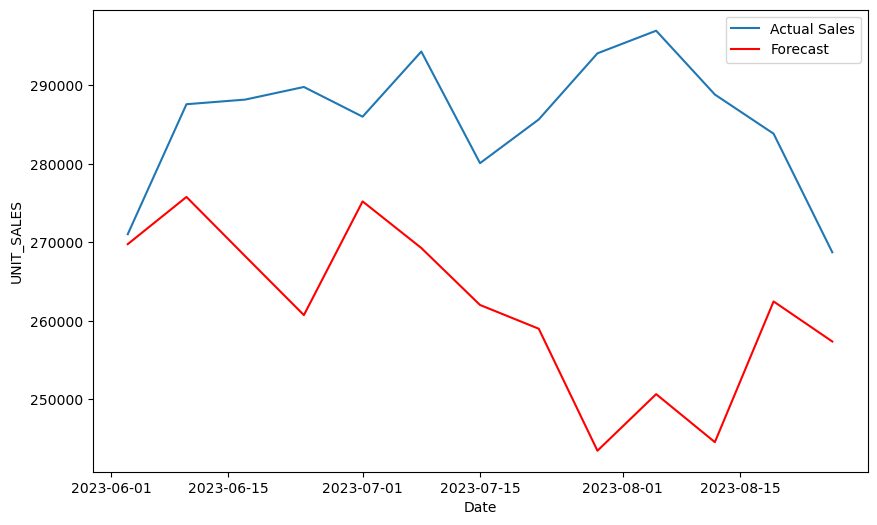

In [14]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(sarima_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Prophet

Prophet is a forecasting tool designed by Facebook for handling time series data that displays patterns on different time scales such as yearly, weekly, and daily. It is especially useful for data with strong seasonal effects and several seasons of historical data.
Prophet works by fitting nonlinear trends with yearly, weekly, and daily seasonality, plus holiday effects. It is robust to missing data and shifts in the trend, and typically requires no manual tuning of parameters.
The model accommodates seasonality through Fourier series and includes components for holidays and special events, making it well-suited for predicting demand for products around specific events or holidays, like Easter.

In [15]:
from prophet import Prophet

df_mod = train_period.reset_index()
df_mod['DATE'] = pd.to_datetime(df_mod['DATE'])
df_mod.columns = ['ds', 'y']

model = Prophet(changepoint_prior_scale=0.1,seasonality_prior_scale=0.5, weekly_seasonality=True)
model.fit(df_mod)

# Forecast the next 52 weeks (1 year)
future = model.make_future_dataframe(periods=53, freq='W-SAT')
forecast = model.predict(future)

prophet_forecast = forecast[['ds','yhat']]
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
prophet_forecast.columns = ['DATE', 'yhat']
prophet_forecast.set_index('DATE', inplace=True)
prophet_forecast = prophet_forecast.asfreq('W-SAT')
prophet_forecast = prophet_forecast.loc[(prophet_forecast.index >= s_date) & (prophet_forecast.index <= e_date)]

20:33:03 - cmdstanpy - INFO - Chain [1] start processing
20:33:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_19324\2900712443.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])


In [16]:
prophet_score = get_scores(test_period.squeeze(), prophet_forecast.loc[(prophet_forecast.index >= s_date) & (prophet_forecast.index <= e_date)].squeeze())

MAE: 14082.66495499823
MSE: 257837638.2131654
RMSE: 16057.32350714668
MAPE: 4.88229507297955%
Direct 'Accuracy' Percentage: 95.11770492702045%


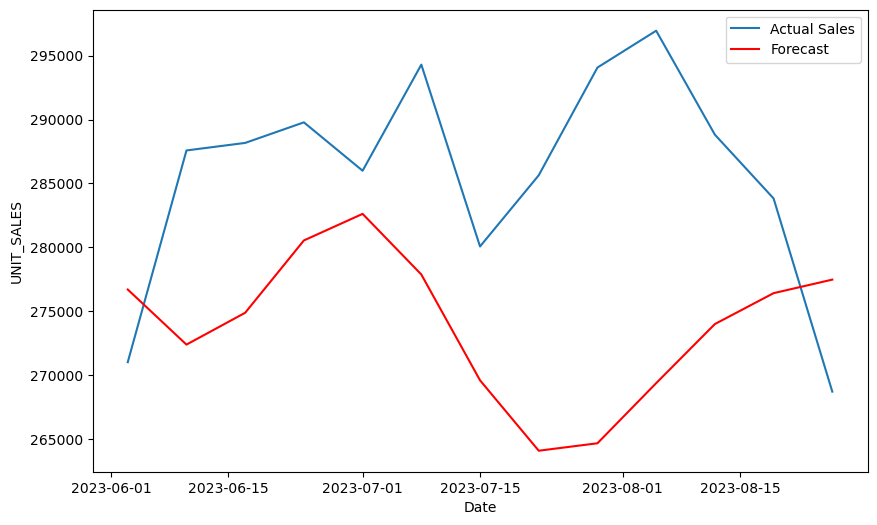

In [17]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(prophet_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Exponential Smoothing

Exponential Smoothing is a time series forecasting method for univariate data that applies smoothing factors to the observations, giving more weight to recent observations while not discarding older observations entirely.
It encompasses simple exponential smoothing for data with no clear trend or seasonality, and extends to Holt’s linear trend model and Holt-Winters’ seasonal model, which can account for both trends and seasonality in the data.
This method is straightforward and computationally efficient, making it a good choice for producing quick forecasts in situations where data patterns are reasonably consistent over time, but may struggle with data that has complex patterns or significant irregularities.

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ExponentialSmoothing Model fitting
model = ExponentialSmoothing(train_period['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.6, smoothing_slope=0.2, smoothing_seasonal=0.2)

# Forecasting

forecast_periods = ((end_forecast - start_forecast).days // 7) + 1

exponential_forecast = model.forecast(forecast_periods)

forecast_dates = pd.date_range(start=start_forecast, periods=forecast_periods, freq='W-SAT')

C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_19324\176272646.py:4: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train_period['UNIT_SALES'], trend='add', seasonal='add', seasonal_periods=52).fit(smoothing_level=0.6, smoothing_slope=0.2, smoothing_seasonal=0.2)
C:\Users\Michael Mendoza\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [19]:
exponential_smoothing_score = get_scores(test_period.squeeze(), exponential_forecast)

MAE: 23907.5251431621
MSE: 744489010.3472316
RMSE: 27285.325916089616
MAPE: 8.281600968319658%
Direct 'Accuracy' Percentage: 91.71839903168035%


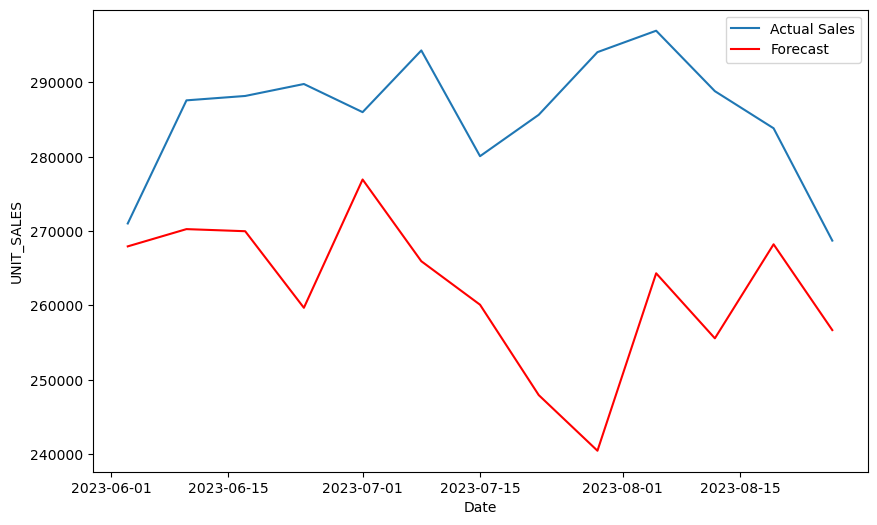

In [20]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_period['UNIT_SALES'], label='Actual Sales')
plt.plot(exponential_forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('UNIT_SALES')
plt.legend()
plt.show()

## Performance Summary

In [21]:
pd.options.display.float_format = '{:.2f}'.format
q2_scores = pd.DataFrame({'Arima':arima_score, 'Sarima':sarima_score, 'Prophet':prophet_score, 'Exponential Smoothing':exponential_smoothing_score}).T
print(q2_scores)

                           mae          mse     rmse  mape  direct_accuracy
Arima                 10610.92 133607735.47 11558.88  3.68            96.32
Sarima                24348.21 801042551.44 28302.70  8.42            91.58
Prophet               14082.66 257837638.21 16057.32  4.88            95.12
Exponential Smoothing 23907.53 744489010.35 27285.33  8.28            91.72


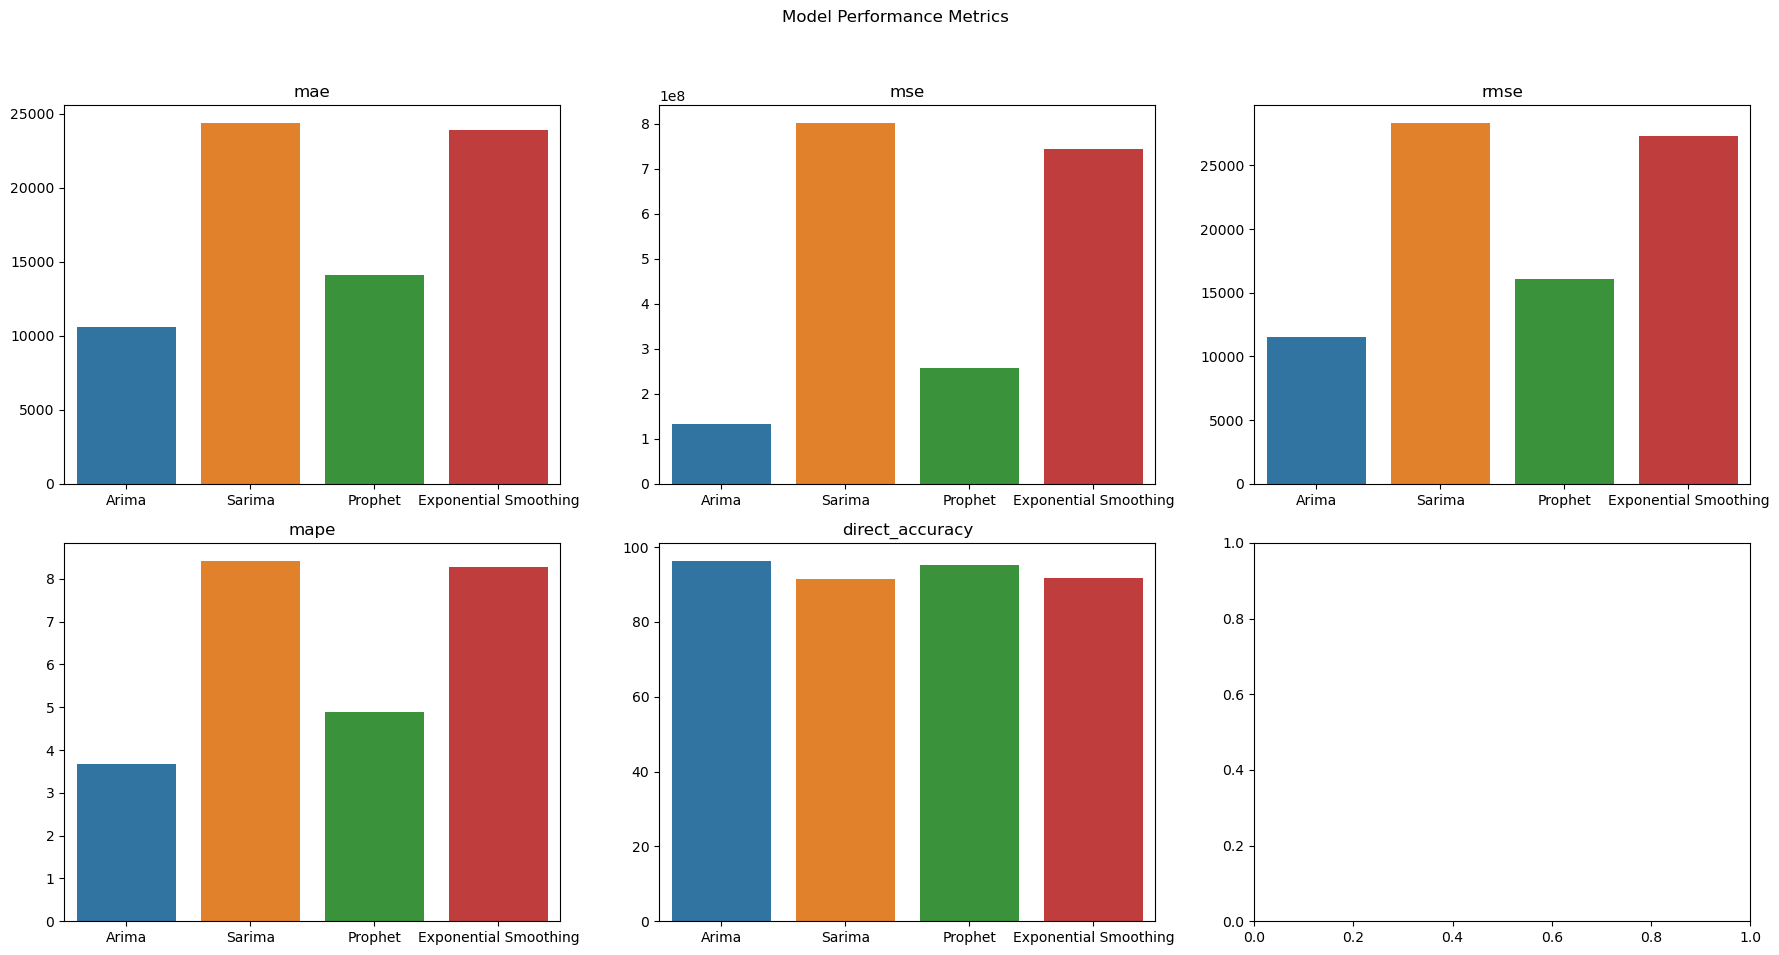

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Model Performance Metrics')

for i, column in enumerate(q2_scores.columns):
    row, col = divmod(i, 3)
    sns.barplot(ax=axes[row, col], x=q2_scores.index, y=q2_scores[column])
    axes[row, col].set_title(column)
    axes[row, col].set_ylabel('')  # Removing the y-label for cleanliness

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on the updated metrics, the Prophet model appears to be the most suitable choice for this scenario, especially when considering the graph resemblance to actual values as a crucial criterion. Although its MAE, MSE, and RMSE values are not the lowest among the compared models, they indicate a reasonable accuracy level in predictions close to the actual values. The Prophet model's MAPE is relatively low, suggesting that its predictions' percentage errors are acceptable, contributing to its overall forecast reliability. Furthermore, its Direct Accuracy is impressively high, only slightly below the highest, showcasing its effectiveness in closely matching the actual trends. Given the importance of graph resemblance to actuals for this analysis, the Prophet model, with its balance between statistical accuracy and visual trend matching, is deemed the most appropriate choice.

## Predicting Easter 2024 using Prophet

In [23]:
df = peppy_regular_ssd_multi_jug[['DATE','UNIT_SALES']].groupby(by="DATE", as_index=False).sum()
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.loc[df.index <= "2023-08-26"]
df = df.asfreq('W-SAT')

In [24]:
from prophet import Prophet

df_mod = df.reset_index()
df_mod['DATE'] = pd.to_datetime(df_mod['DATE'])
df_mod.columns = ['ds', 'y']

model = Prophet(changepoint_prior_scale=0.1,seasonality_prior_scale=0.5, weekly_seasonality=True)
model.fit(df_mod)

future = model.make_future_dataframe(periods=13, freq='W-SAT')
forecast = model.predict(future)

prophet_forecast = forecast[['ds','yhat','yhat_upper','yhat_lower']]
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
prophet_forecast.columns = ['DATE', 'yhat','yhat_upper','yhat_lower']
prophet_forecast.set_index('DATE', inplace=True)
prophet_forecast = prophet_forecast.asfreq('W-SAT')
prophet_forecast = prophet_forecast.loc[(prophet_forecast.index >= "2023-09-02")]

20:33:04 - cmdstanpy - INFO - Chain [1] start processing
20:33:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Michael Mendoza\AppData\Local\Temp\ipykernel_19324\963624670.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])


In [25]:
prophet_forecast

,yhat,yhat_upper,yhat_lower
DATE,,,
2023-09-02,285476.40,298778.29,271838.69
2023-09-09,288354.50,300856.25,276032.32
2023-09-16,289057.31,302472.57,274802.73
2023-09-23,287248.53,300958.92,273797.52
2023-09-30,285106.30,298506.32,271294.70
2023-10-07,284271.78,298363.42,271306.87
2023-10-14,283922.05,297361.37,270622.10
2023-10-21,282352.50,296781.29,268788.65
2023-10-28,279677.03,294189.70,266454.82


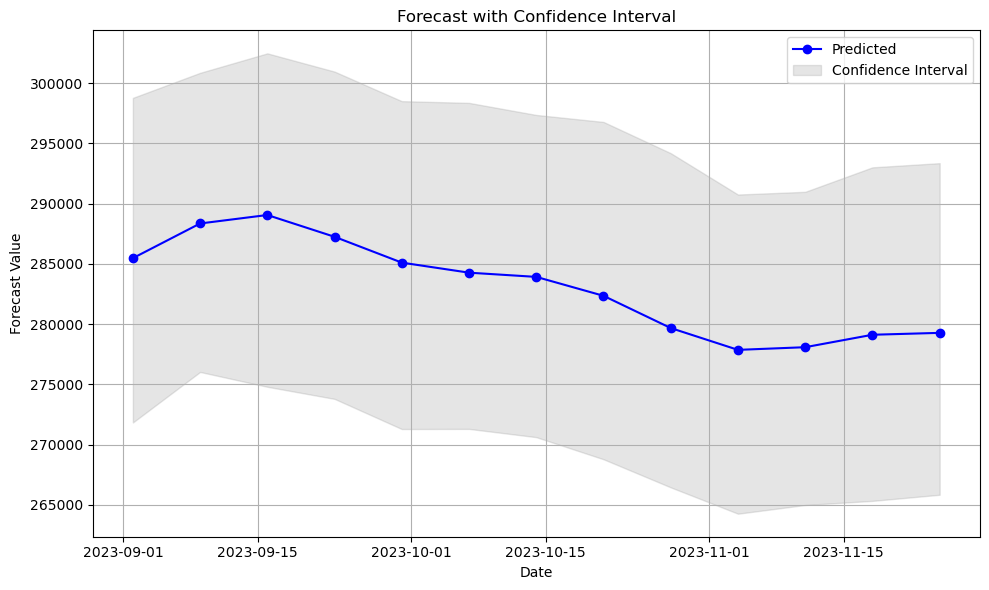

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Predicted', color='blue', marker='o')
plt.fill_between(prophet_forecast.index, prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Forecast Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary

The forecasting analysis for Swire's upcoming beverage, the Peppy Gentle Drink in "Pink Woodsy" flavor, packaged in a .5L Multi Jug, focuses on the product's demand projection for a 13-week span around the Southern region's Easter 2024 period. The data was meticulously curated to match the product's attribute,, caloric segment, type, manufacturer, and packaging, from a comprehensive market demand dataset. This strategic approach allowed for an accurate representation and analysis relevant to the product's market introduction.

Seveted forecasting models were employed, including ARIMA, SARIMA, Prophet, and Exponential Smoothing, each evaluated against critical performance metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Direct 'Accuracy' Percentage. These metrics provided a comprehensive assessment of each model's accuracy and reliability in predicting future sales demand.

The Prophet model emerged as the most fitting choice for this specific forecasting task. While its MAE, MSE, and RMSE values did not register as the absolute lowest among the models evaluated, they were nonetheless indicative of a commendably high level of prediction accuracy. The Prophet model's relatively low MAPE and high Direct Accuracy Percentage further affirmed its efficacy in closely mirroring actual sales trends, a crucial factor for this analysis.

The demand forecast through the Prophet model reveals an anticipated fluctuation in sales over the target period, with projections highlighting key trends and potential peak demand times around Easter 2024. This predictive insight is invaluable for Swire in strategizing production, inventory, and marketing efforts to optimally meet anticipated consumer demand. By effectively leveraging the Prophet model's forecast, Swire can ensure product availability aligns with market demand, maximizing sales potential and customer satisfaction during this critical launch 






24.